In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
from ans import generate_string, code_rans, decode_rans
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
def run_trial(freqs, label, msg_len, N, quant_bits, renorm_bits, ALPHABET=('a', 'b')):
    d = {}
    d['freqs'] = freqs
    d['label'] = label
    d['probs'] = [x / (1 << quant_bits) for x in freqs]
    d['length_symbol'] = msg_len
    d['length_bits'] = msg_len * np.log2(len(ALPHABET))
    d['trials'] = N
    entropy = []
    code_length = []
    for i in range(N):
        msg = generate_string(msg_len, alphabet=ALPHABET, prob=d['probs'])
        try:
            codes = code_rans(msg, ALPHABET, freqs=freqs, quant_bits=quant_bits, renorm_bits=renorm_bits)
            decoded_msg = decode_rans(codes, ALPHABET, freqs=freqs, quant_bits=quant_bits, renorm_bits=renorm_bits)
           
            # Each code is stored as a `renorm_bit` number, except last number which is `2 * renorm_bits`
            entropy.append(renorm_bits * len(codes) + renorm_bits)
            code_length.append(len(codes))
            assert decoded_msg == msg, msg
        except Exception as e:
            print('Msg: ', msg)
            print('freqs: ', freqs)
            print('label: ', label)
            print('quant_bits: ', quant_bits)
            print('renorm_bits: ', renorm_bits)
            print('alphabet: ', ALPHABET)
            print(e)
            raise e
           
    d['quant_bits'] = quant_bits
    d['renorm_bits'] = renorm_bits
    d['entropy'] = pd.Series(entropy)
    d['mean_code_length'] = pd.Series(code_length).mean()
    d['actual_bits'] = d['entropy'].mean()
    d['ideal_bits'] = msg_len * sum([-x * np.log2(x) for x in d['probs']])
   
    d['actual_ratio'] = d['length_bits'] / d['entropy'].mean()
    d['ideal_ratio'] = d['length_bits'] / d['ideal_bits']
    return d

In [3]:
def norm_freqs(freqs, quant_bits):
    ''' Generate an integer frequency array that sums to exactly 1 << quant_bits'''
    result = []
    total = (1 << quant_bits)
    for i, x in enumerate(freqs):
        val = max(np.round(total * x / sum(freqs[i:])), 1)
        result.append(int(val))
        total -= result[-1]
        
    assert sum(result) == (1 << quant_bits), (sum(result), result)
    return [int(x) for x in result]

# Vary Message Length and Distributions

In [4]:
alpha = [str(x + 1) for x in (range(256))]
quant_bits = 15
renorm_bits = 24
N = 50
distributions = {
    'uniform': [int((1 << quant_bits) / 256)] * 256, # uniform
    'power_50': norm_freqs([x**50 for x in range(1, 257)], quant_bits),
    'power_10': norm_freqs([x**10 for x in range(1, 257)], quant_bits),
    'power_2': norm_freqs([x**2 for x in range(1, 257)], quant_bits),
}

experiments = []
for msg_len in [10, 100, 500, 1000, 10000]:
    for label, freqs in distributions.items():
        d = run_trial(freqs, label, msg_len, N=N, quant_bits=quant_bits, renorm_bits=renorm_bits, ALPHABET=alpha)
        experiments.append(d)

df = pd.DataFrame(experiments)
df.head()

,freqs,label,probs,length_symbol,length_bits,trials,quant_bits,renorm_bits,entropy,mean_code_length,actual_bits,ideal_bits,actual_ratio,ideal_ratio
0,"[128, 128, 128, 128, 128, 128, 128, 128, 128, ...",uniform,"[0.00390625, 0.00390625, 0.00390625, 0.0039062...",10,80.0,50,15,24,0 120 1 120 2 120 3 120 4 ...,4.00,120.00,80.000000,0.666667,1.000000
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_50,"[3.0517578125e-05, 3.0517578125e-05, 3.0517578...",10,80.0,50,15,24,0 72 1 72 2 72 3 72 4 72 5...,2.04,72.96,38.282819,1.096491,2.089710
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_10,"[3.0517578125e-05, 3.0517578125e-05, 3.0517578...",10,80.0,50,15,24,0 96 1 96 2 96 3 96 4 ...,3.02,96.48,58.904159,0.829187,1.358138
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_2,"[3.0517578125e-05, 3.0517578125e-05, 3.0517578...",10,80.0,50,15,24,0 120 1 120 2 120 3 120 4 ...,3.58,109.92,73.814703,0.727802,1.083795
4,"[128, 128, 128, 128, 128, 128, 128, 128, 128, ...",uniform,"[0.00390625, 0.00390625, 0.00390625, 0.0039062...",100,800.0,50,15,24,0 840 1 840 2 840 3 840 4 ...,34.00,840.00,800.000000,0.952381,1.000000


Text(0.5, 1.0, 'Compression Ratio vs. Message Length for Various Distributions')

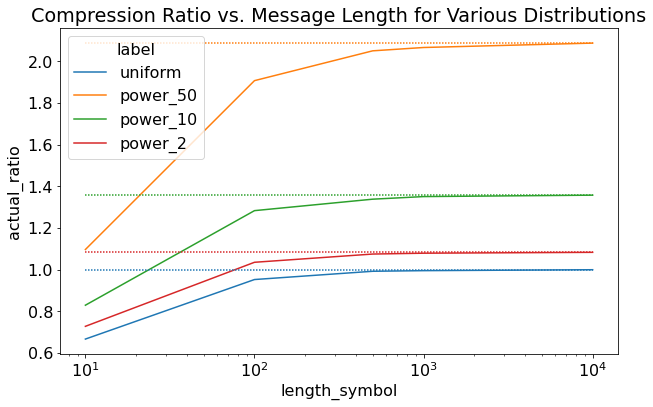

In [5]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 6))
num_lines = len(set(df['label']))
sns.lineplot(ax=ax, data=df, x='length_symbol', y='actual_ratio', hue='label',
             palette=sns.color_palette("tab10", n_colors=len(set(df['label']))))
sns.lineplot(ax=ax, data=df, x='length_symbol', y='ideal_ratio', hue='label', style=[1] * len(df),
             palette=sns.color_palette("tab10", n_colors=num_lines),
             dashes=[(1, 1)], legend=False)
ax.set(xscale='log')
plt.title('Compression Ratio vs. Message Length for Various Distributions')

# Vary Quant/Renorm Bits

In [6]:
alpha = [str(x + 1) for x in (range(256))]
quant_bits = 15
renorm_bits = 24
N = 50
msg_len = 1000
label = 'power_50'

experiments = []
for quant_bits in [8, 12, 16, 20, 24]:
    for renorm_add in [0, 4, 8]:
        renorm_bits = quant_bits + renorm_add
        freqs = norm_freqs([x**50 for x in range(1, 257)], quant_bits)
        d = run_trial(freqs, label, msg_len, N=N, quant_bits=quant_bits, renorm_bits=renorm_bits, ALPHABET=alpha)
        experiments.append(d)

df = pd.DataFrame(experiments)
df.head()

,freqs,label,probs,length_symbol,length_bits,trials,quant_bits,renorm_bits,entropy,mean_code_length,actual_bits,ideal_bits,actual_ratio,ideal_ratio
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_50,"[0.00390625, 0.00390625, 0.00390625, 0.0039062...",1000,8000.0,50,8,8,0 8008 1 8008 2 8008 3 8008 4 ...,1000.00,8008.00,8000.000000,0.999001,1.000000
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_50,"[0.00390625, 0.00390625, 0.00390625, 0.0039062...",1000,8000.0,50,8,12,0 8016 1 8016 2 8016 3 8016 4 ...,667.00,8016.00,8000.000000,0.998004,1.000000
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_50,"[0.00390625, 0.00390625, 0.00390625, 0.0039062...",1000,8000.0,50,8,16,0 8016 1 8016 2 8016 3 8016 4 ...,500.00,8016.00,8000.000000,0.998004,1.000000
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_50,"[0.000244140625, 0.000244140625, 0.00024414062...",1000,8000.0,50,12,12,0 4380 1 4320 2 4224 3 4332 4 ...,355.66,4279.92,4263.102631,1.869194,1.876568
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",power_50,"[0.000244140625, 0.000244140625, 0.00024414062...",1000,8000.0,50,12,16,0 4336 1 4096 2 4336 3 4288 4 ...,265.54,4264.64,4263.102631,1.875891,1.876568


Text(0.5, 1.0, 'Compression Ratio vs. Quantization Bits for Various Additional Renormalization Bits')

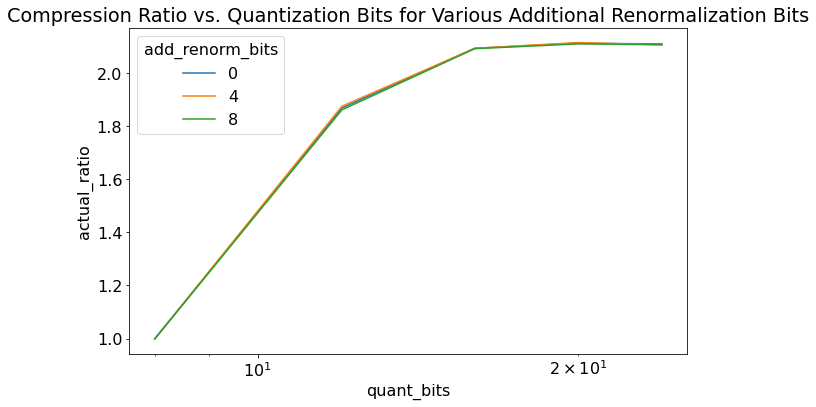

In [7]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 6))
num_lines = len(set(df['label']))
df['add_renorm_bits'] = df['renorm_bits'] - df['quant_bits']
sns.lineplot(ax=ax, data=df, x='quant_bits', y='actual_ratio', hue='add_renorm_bits',
             palette=sns.color_palette("tab10", n_colors=len(set(df['add_renorm_bits']))))
ax.set(xscale='log')
plt.title('Compression Ratio vs. Quantization Bits for Various Additional Renormalization Bits')

# Scratch

In [8]:
from math import floor

freqs = [5, 2, 1]
CDF = [sum(freqs[:0]), sum(freqs[:1]), sum(freqs[:2]), sum(freqs)]
n = 3

# C(x, s)
print(freqs)
s=2
for x in range(40, 50):
    #print(floor(x / freqs[s]), (floor(x / freqs[s]) << n), (x % freqs[s]), CDF[s])
    prex = x
    x = (floor(x / freqs[s]) << n) + (x % freqs[s]) + CDF[s]
    print(prex, " ===> ", x)

[5, 2, 1]
40  ===>  327
41  ===>  335
42  ===>  343
43  ===>  351
44  ===>  359
45  ===>  367
46  ===>  375
47  ===>  383
48  ===>  391
49  ===>  399


In [9]:
(0.001 + 0.1 - 0.1) * 10000000000000000

10000000000000.01